# Toy Dataset

This notebook exists to work on a smaller amount of data (only 5 species of birds) in order to find problems with the modeling process.

In [1]:
import os
import numpy as np
from torch.utils.data import Dataset, DataLoader
from pathlib import Path
from skimage import io, transform
from torchvision import utils, transforms
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size
        
    def __call__(self, sample):
        image, species = sample['image'], sample['species']
        
        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size
        
        new_h, new_w = int(new_h), int(new_w)
        img = transform.resize(image, (new_h, new_w))
               
        return {'image': img, 'species': species}
    
    
class RandomCrop(object):
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size
            
    def __call__(self, sample):
        image, species = sample['image'], sample['species']
        
        h, w = image.shape[:2]
        new_h, new_w = self.output_size
        
        top = np.random.randint(0, h-new_h)
        left = np.random.randint(0, w-new_w)
        
        image = image[top: top+new_h,
                      left: left+new_w]
        
        return {'image': image, 'species': species}
    
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""
    def __call__(self, sample):
        image, species = sample['image'], sample['species']
        
        # swap color axis because
        # numpy iamge: HxWxC
        # torch image: CxHxW
        image = image.transpose((2, 0, 1))
        return {'image': torch.from_numpy(image),
                'species': species}
    
    
def show_duck(image):
    plt.imshow(image)
    plt.pause(0.001)

    
class BirdDataset(Dataset):
    def __init__(self, root_dir, img_lst, transform=None):
        """To be used when iterating over the 
        files within the root directory"""
        self.root_dir = Path(root_dir)
        self.img_lst = img_lst
        self.transform = transform
    
    def create_encoder(self):
        """Convert all species names to integers"""
        encoding_dict = {}
        
        for img in self.img_lst:
            # relies on specific file naming pattern
            species = img.split('0')[0]
            
            if species not in encoding_dict.keys():
                encoding_dict[species] = len(encoding_dict)
        return encoding_dict
    
    def __len__(self):
        return len(self.img_lst)
    
    def __getitem__(self, idx:int) -> dict:
        """For any index in the range of img_lst
        it maps image to the image values
        and species to the type of bird"""
        img_path = self.root_dir/self.img_lst[idx]
        image = io.imread(img_path)

        # relies on specific file naming pattern
        species = self.img_lst[idx].split('0')[0]

        # naughty global variable: look to fix in future
        species = encoder[species]
            
        sample = {'image': image, 'species': species}
        
        if self.transform:
            sample = self.transform(sample)
            
        return sample
    
    
def show_birds_batch(sample_batched):
    """Show species images for a batch"""
    images_batch, species_batch = sample_batched['image'], sample_batched['species']
    batch_size = len(images_batch)
    im_size = images_batch.size(2)
    
    grid = utils.make_grid(images_batch)
    plt.imshow(grid.numpy().transpose((1, 2, 0)))
    
    for i in range(batch_size):      
        plt.title('Batch from dataloader')

0 torch.Size([4, 3, 224, 224]) tensor([2, 4, 0, 1])


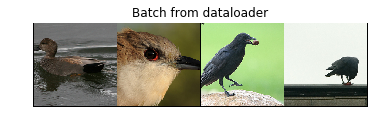

1 torch.Size([4, 3, 224, 224]) tensor([4, 1, 2, 3])


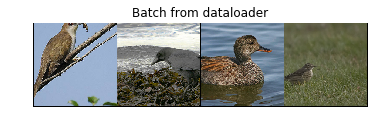

2 torch.Size([4, 3, 224, 224]) tensor([4, 4, 0, 2])


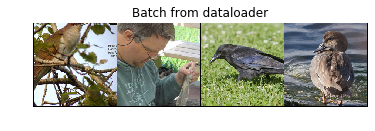

3 torch.Size([4, 3, 224, 224]) tensor([0, 4, 4, 3])


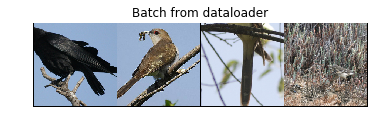

4 torch.Size([4, 3, 224, 224]) tensor([4, 4, 3, 3])


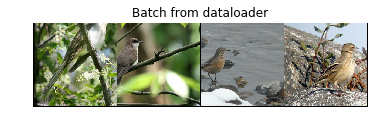

In [3]:
toy_root_dir = Path('/Users/jon_ross/sideProj/website/images/toy')
toy_img_lst = os.listdir('images/toy')
toy_birds_dataset = BirdDataset(toy_root_dir, toy_img_lst)
encoder = toy_birds_dataset.create_encoder()

toy_birds_dataset = BirdDataset(toy_root_dir, toy_img_lst,
                                  transform=transforms.Compose([
                                                Rescale(256),
                                                RandomCrop(224),
                                                ToTensor()
                                  ]))


toy_dataloader = DataLoader(toy_birds_dataset, batch_size=4,
                              shuffle=True, num_workers=4)

for i_batch, sample_batched in enumerate(toy_dataloader):
    print(i_batch, sample_batched['image'].size(),
          sample_batched['species'])
    plt.figure()
    show_birds_batch(sample_batched)
    plt.axis('off')
    plt.ioff()
    plt.show()
    
    if i_batch == 4:
        break

In [4]:
class ToyNetwork(nn.Module):
    def __init__(self):
        super(ToyNetwork, self).__init__()
        # Conv arguments were arbitrarily changed to require less model parameters
        self.conv1 = nn.Conv2d(3, 4, 8, stride=2)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(4, 10, 8, stride=2)
        # First linear argument is a function of image size and conv parameters
        self.fc1 = nn.Linear(10*12*12, 1000)
        self.fc2 = nn.Linear(1000, 200)
        self.fc3 = nn.Linear(200, 5)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
#         print(x.shape)
        x = x.view(-1, 10*12*12)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

toynet = ToyNetwork()

In [5]:
criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0)
optimizer = optim.Adam(toynet.parameters(), lr=0.0001)

In [6]:
from torch.nn import LogSoftmax

num_epocs = 2
m = LogSoftmax()
losses = []

for epoch in range(num_epocs):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(toy_dataloader, 0):
        # get the inputs
        inputs = data['image'].float()
        labels = data['species']
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = toynet(inputs)

#         print(m(outputs))
#         print(outputs)
#         print('\n')
        
        loss = criterion(outputs, labels)
        losses += [loss.item()]
        loss.backward()
        optimizer.step()

        # print statistics
#         running_loss += loss.item()
#         if i % 200 == 199:    # print every 200 mini-batches
#             print('[%d, %5d] loss: %.3f' %
#                   (epoch + 1, i + 1, running_loss / 200))
#             running_loss = 0.0
    running_loss += loss.item()
    if epoch % 20 == 0:
        print(running_loss / 20)
        running_loss = 0.0
#     if epoch % 100 == 0:
#     print(loss.item())

print('Finished Training')

0.08587378263473511
Finished Training


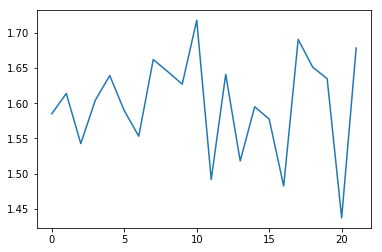

In [7]:
import seaborn as sns
%matplotlib inline

sns.lineplot(x=range(len(losses)), y=losses)